# Практическая работа №1: Изучение возможности библиотек Python для решения задач цифровой обработки сигналов

Выполнил студент гр. 9383 Камзолов Никита, вариант 5.

## Постановка задачи

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

## Выполнение работы

In [92]:
from scipy.io import wavfile
sound_rate, sound = wavfile.read('lab1.wav') #sound одномерный, поэтому будем рассматривать

In [93]:
import matplotlib.pyplot as plt
import numpy as np

### Построение огибающей

Имеется сигнал $x(i), i = 0, 1, ..., N - 1$. Хотим построить огибоющую $y(j), j = 0, 1, ..., n-1$. Пусть $ m = \begin{bmatrix} \frac{N}{n} \end{bmatrix}$ - число точек в интервале усреднения. Тогда $y(j) = \frac{1}{m}\sum_{k = mj}^{mj+m-1} \left | x(k) \right |$ 

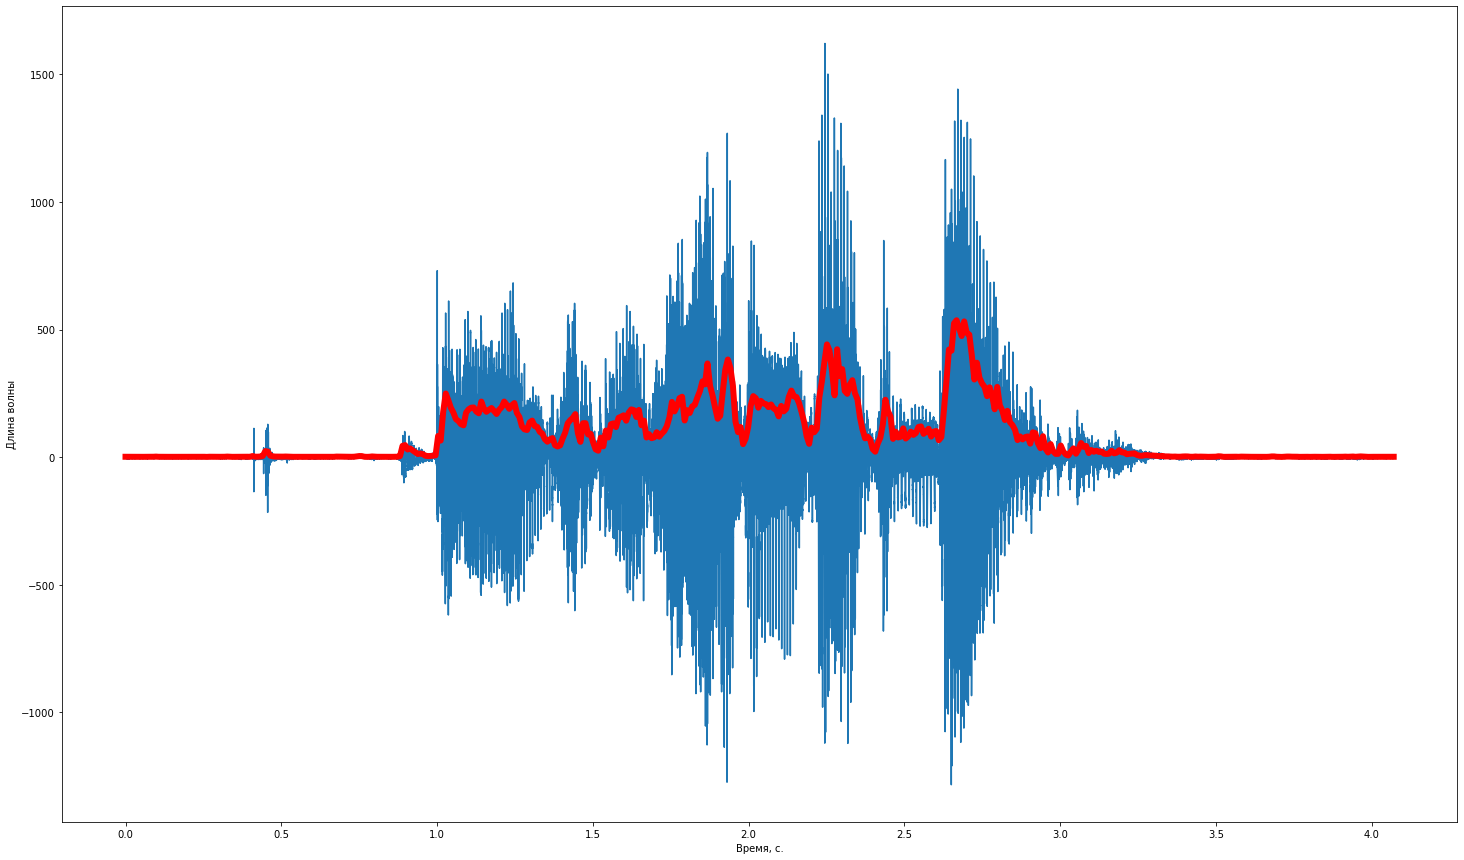

In [94]:
sound_time = sound.size / sound_rate
n = 500
m = int(sound.size / n)
x = np.linspace(0, sound_time, sound.size)
x_curve = np.linspace(0, sound_time, n)
envelope_line = np.zeros(n)
for i in range(n):
    temp_sum = 0
    for j in range (m * i, m * i + m - 1):
         temp_sum += abs(sound[j])
    envelope_line[i] = temp_sum / m

plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, sound)
plt.plot(x_curve, envelope_line, linewidth = 6, color = "red")
plt.xlabel("Время, с.")
plt.ylabel("Длина волны")
plt.show()

### Полосовой фильтр

Фильтрация полосовым фильтром. 
Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. Порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}}{F_{d}}$.

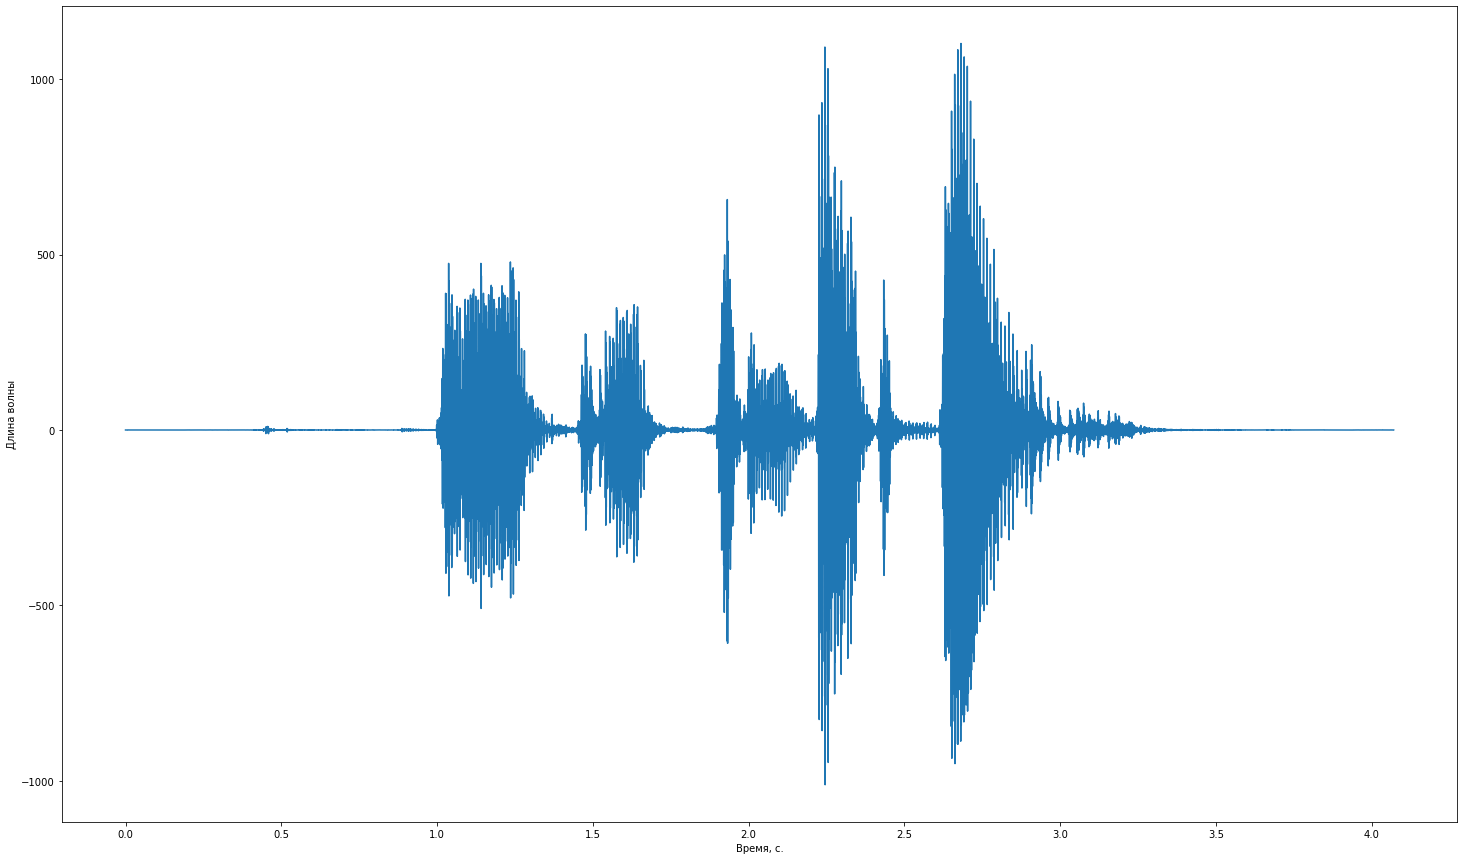

In [95]:
from scipy import signal
Fs1 = 400
Fs2 = 900
wn = (2 * Fs1 / sound_rate, 2 * Fs2 / sound_rate)
m = 2
b, a = signal.butter(m, wn, "bandpass")
filtered_sound = signal.filtfilt(b, a, sound)

plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, filtered_sound)
plt.xlabel("Время, с.")
plt.ylabel("Длина волны")
plt.show()
wavfile.write("filtered.wav", sound_rate, filtered_sound.astype(np.int16))


### Детектор сигнал/шум

Определяем среднее сигнала по амплитуде(без учета знака):
$mid = \frac{1}{N}\sum{k=0}{N-1}|x(k)|$

Определяем порог детектора - $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально. Задаем величину "провала"(в отсчетах) - $k$. Обозначим $y(i)$ - сигнал после детектирования. 

1. **Событие "начало сигнала"**. Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i) = x(i)$.
2. **Событие "окончание сигнала"**. Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i) = 0$.

87.3499065994524


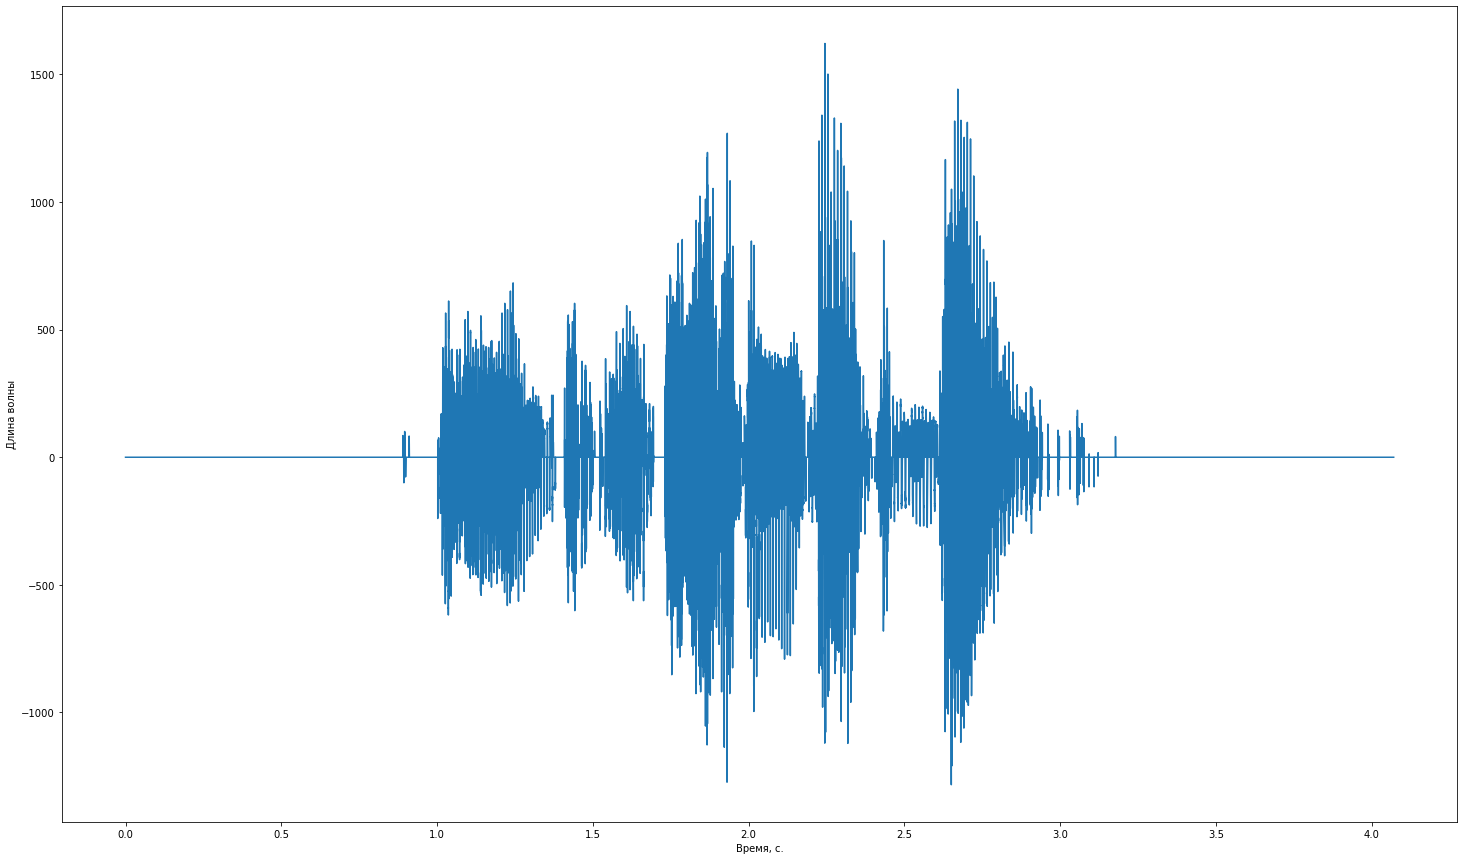

In [96]:
sum = 0
for i in range(sound.size):
    sum += abs(sound[i])
mid = sum / sound.size
a = 0.8
Th = a * mid
print(mid)
k = 10
signal_c = 0
not_signal_c = 0
isSignal = False
detected = np.zeros(sound.size)
for i in range(sound.size):
    if abs(sound[i]) > Th:
        signal_c += 1
        if signal_c >= k: 
            signal_c = k
            isSignal = True
            detected[i] = sound[i]
        continue
    if not isSignal:
        signal_c = 0
        continue
    if isSignal:
        signal_c -= 1
        if signal_c <= 0: 
            isSignal = False
        else: 
            detected[i] = sound[i]

plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, detected)
plt.xlabel("Время, с.")
plt.ylabel("Длина волны")
plt.show()
wavfile.write("detector.wav", sound_rate, detected.astype(np.int16))


### Эхо (простейший ревербератор)

In [97]:
Di = np.zeros(8)
gamma = 0.9 
max = float(input("Введите максимальную задержку(в секундах): "))
Di[0] = max
for i in range(1, 8):
    Di[i] = max * (2 ** ((-i)/8))
alpha = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
all_samples = []
for i in range(8):
    new_sound = alpha[i] * sound 
    all_samples.append(new_sound)
Fs = 900
wn = 2 * Fs / sound_rate
m = 1
b, a = signal.butter(m, wn, "lowpass")
for i in range(8):
    all_samples[i] = signal.filtfilt(b, a, all_samples[i])
    all_samples[i] = all_samples[i] * gamma
echo_sound = np.zeros(int((np.sum(Di) + len(sound) / sound_rate + 1) * sound_rate))
for i in range(8):
    if i >= 1:
        Di[i] += Di[i-1]
    for j in range(len(all_samples[i])):
        echo_sound[j + int(Di[i] * sound_rate)] += all_samples[i][j]
for i in range(len(sound)):
    echo_sound[i] += sound[i]
wavfile.write("echo.wav", sound_rate, echo_sound.astype(np.int16))


    

Введите максимальную задержку(в секундах): 0.9


### Эффект "Distortion"

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i)$, $i = 0, 1, ..., N-1$. Пользователь задает **порог** - $Th$ и максимальное значение сигнала $Max > Th$. Тогда $Y(i) = \left\{\begin{matrix}
 & x(i), |x(i)| < Th\\ 
 & Max * sign(x(i)), |x(i)| > Th
\end{matrix}\right.$


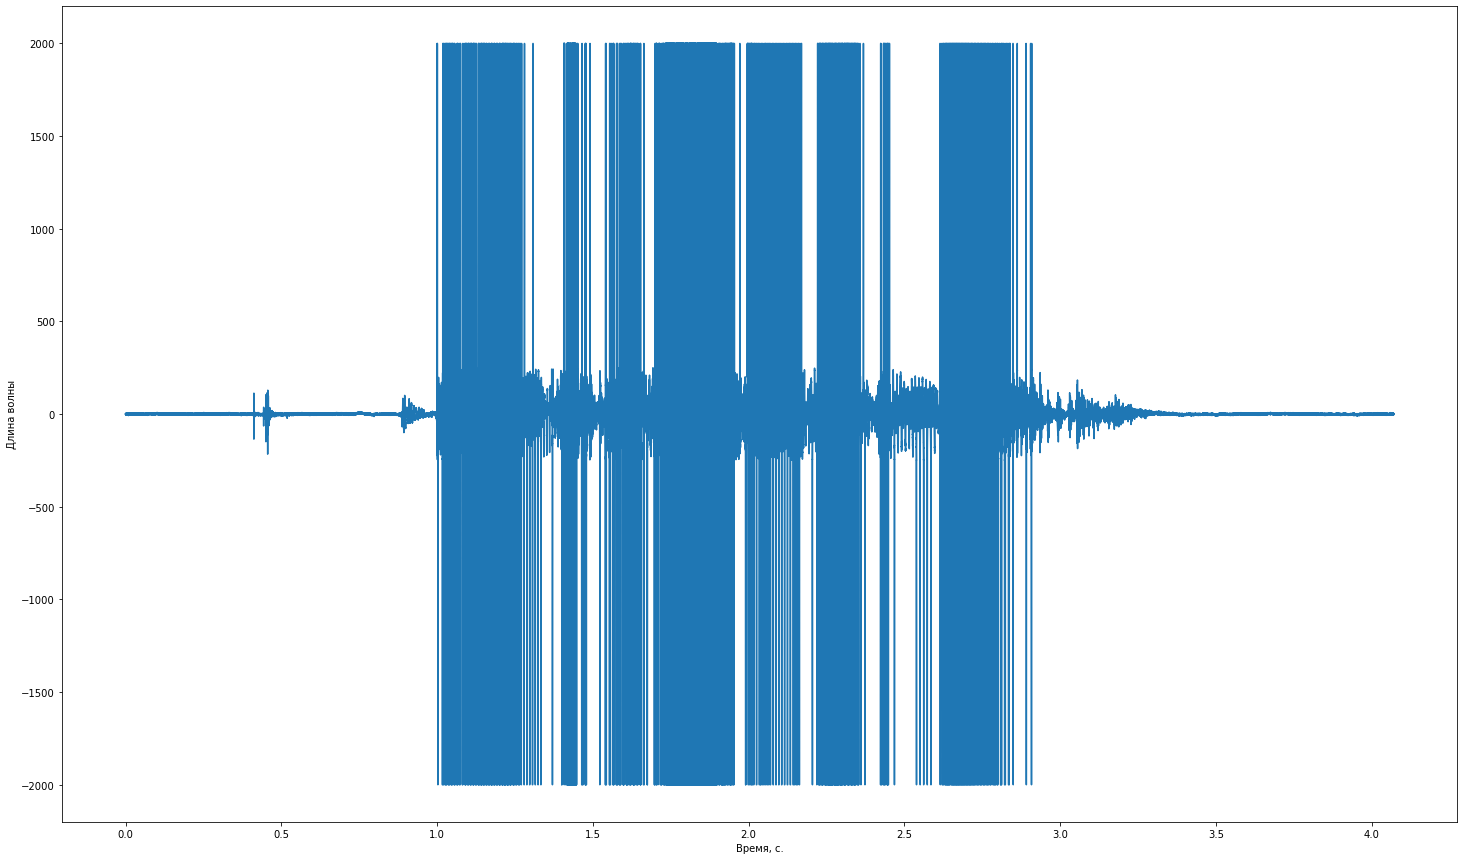

In [98]:
Th = 250
max = 2000
distortion = np.zeros(sound.size)
for i in range(sound.size):
    if (abs(sound[i]) < Th):
        distortion[i] = sound[i]
    else:
        distortion[i] = max * np.sign(sound[i])
        
plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, distortion)
plt.xlabel("Время, с.")
plt.ylabel("Длина волны")
plt.show()
wavfile.write("distortion.wav", sound_rate, distortion.astype(np.int16))
        

### Вывод
В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решения задач цифровой обработки сигналов